In [1]:
import networkx as nx
import pickle
import random
import scipy
from scipy.sparse import tril, find
import django
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
import igraph
from django.core.management import call_command

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.tasks import *
import tmv_app
import tmv_app.utils.plotting as tplots
from tmv_app.utils.plotting import SquareCollection, CoordSquare

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.decomposition.nmf module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
run_id = 2861
stat = RunStats.objects.get(pk=run_id)
q = stat.query

# position the papers in a 2-dimensional topic space, with perplexity p
# unless you pass the argument force_overwrite=True, the results are not recalculated
s = 0
p = 100
tsne_results, r_ind = stat.calculate_tsne('tsne_results/data', p)

In [8]:
tsne_results # x, y coordinates of the tsne (i.e. place of document after dimensionality reduction)

array([[ -5.34442698,  -4.18569191],
       [ -0.94217383, -12.68833348],
       [ 19.69682765,   2.62677495],
       ...,
       [  8.70657196, -14.52412008],
       [ 17.22105435,   1.34626745],
       [  0.34682421,  12.81997113]])

In [9]:
r_ind #matching document for above

array([3440643, 3538950, 1474569, ..., 3538941, 1474558, 1277951])

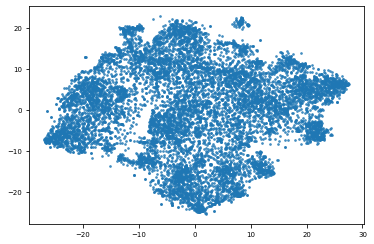

In [10]:
plt.scatter(tsne_results[:,0],tsne_results[:,1], s=3, alpha=0.7) #all of the docs

In [11]:
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']
no_oecd_ids = r_ind

oecd_cats = [
    {'wc__oecd': 'Agricultural Sciences'},
    {'wc__oecd': 'Engineering and Technology'},
    {'wc__oecd': 'Humanities'},
    {'wc__oecd': 'Medical and Health Sciences'},
    {'wc__oecd': 'Natural Sciences'},
    {'wc__oecd': 'Social Sciences'},
    {'wc__oecd': None}
]

oecd_df = pd.DataFrame()
for i,c in enumerate(oecd_cats):
    ds = Doc.objects.filter(query=q,wc__oecd=c['wc__oecd']).values_list('id', flat=True)
    c['docs'] = list(set(ds) & set(r_ind))
    oecd_df = pd.concat([oecd_df,pd.DataFrame({
        "oecd": c['wc__oecd'], "doc": c['docs']
    })])
    c['n_docs'] = len(c['docs'])
    c['name'] = c['wc__oecd']
    c['color'] = colors[i]
    c["dis"] = np.argwhere(np.isin(r_ind,c['docs']))
    no_oecd_ids = no_oecd_ids[np.isin(no_oecd_ids,c['docs'],invert=True)]
    
from operator import itemgetter
oecd_cats = sorted(oecd_cats, key=itemgetter('n_docs'), reverse=True) #oecd_cats is a dict with colour & doc IDs


calculating points took 0.167s.
couldn't find a cluster for {find, howev, suggest}
couldn't find a cluster for {differ, compar, across}
couldn't find a cluster for {provid, sever, one}
couldn't find a cluster for {studi, present, evalu}


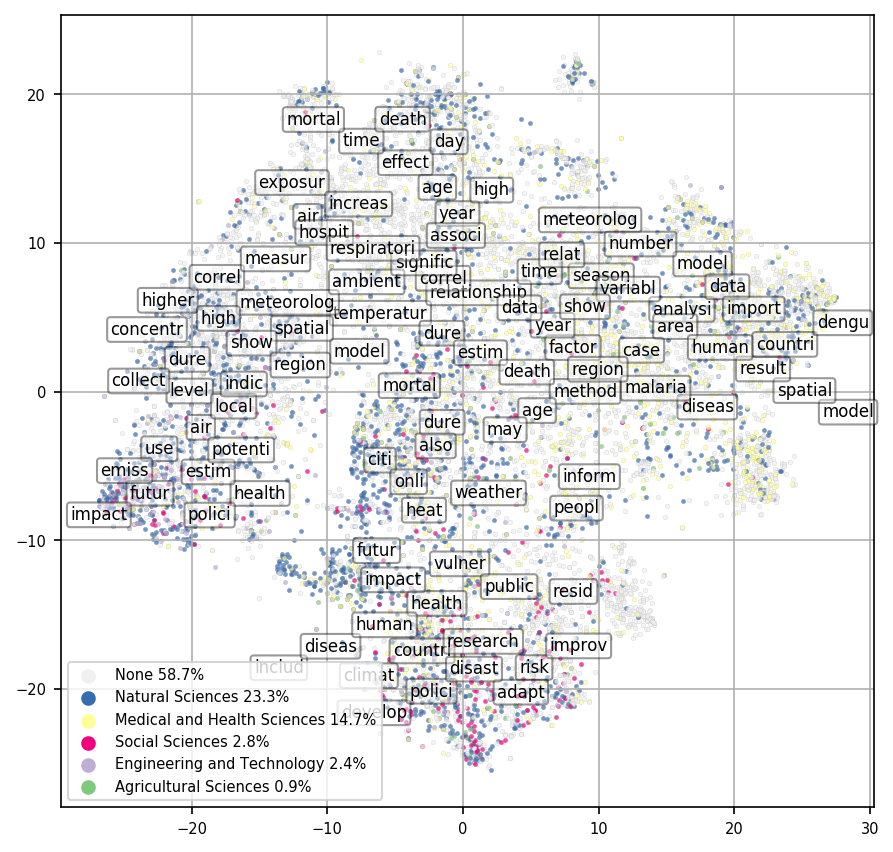

In [13]:
fig, ax = plt.subplots( figsize=(7,7), dpi=150)

tops = Topic.objects.filter(run_id=run_id)

tplots.plot_tsne(
    r_ind,
    tsne_results,
    oecd_cats,
    [],
    verbose=True,
    ax=ax,
    psize=5, #pointsize
    topics=tops, 
    t_thresh=0.94, # threshold for percentile of document topic scores above which to include
    min_cluster=80, # minimum number of documents to label cluster
    eps=5, # Input for clustering, higher values allow larger distances between docs 
    draw_highlight_points=False,
    adjust=True,
    dot_legend=True,
    #words_only=False,
    words_only=True
)

calculating points took 0.139s.


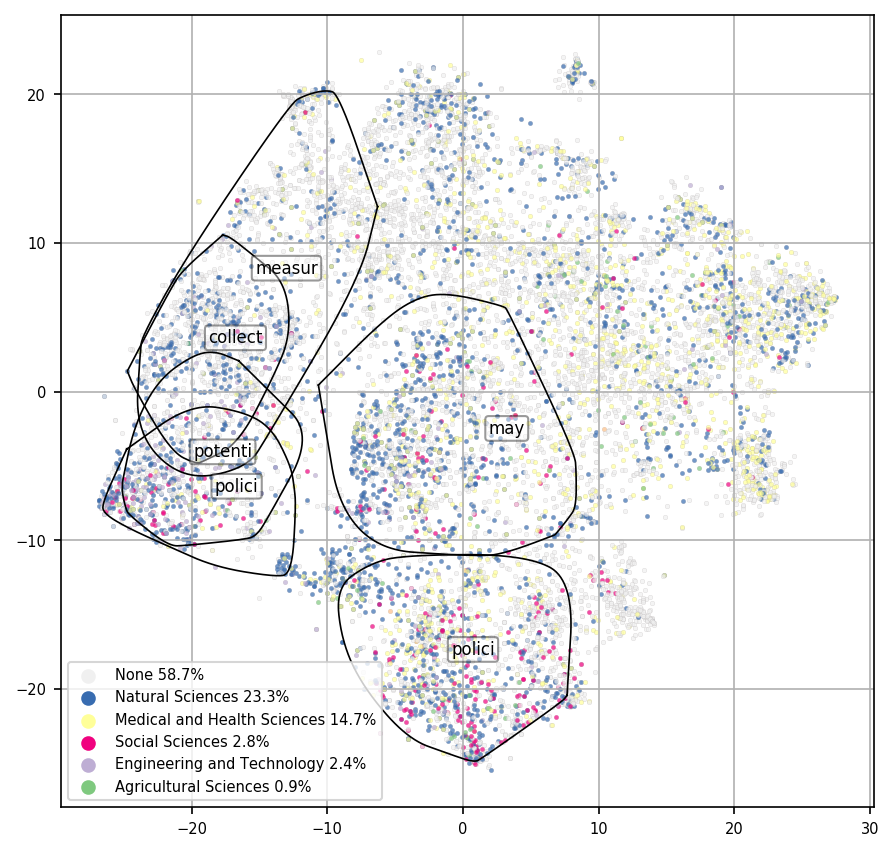

In [14]:
#Draw bounding boxes for some topics
fig, ax = plt.subplots( figsize=(7,7), dpi=150)

tops = Topic.objects.filter(run_id=run_id)[:5] #take only first 5 topics in this case

tplots.plot_tsne(
    r_ind,
    tsne_results,
    oecd_cats,
    [],
    verbose=True,
    ax=ax,
    psize=5, #pointsize
    topics=tops, 
    t_thresh=0.94, # threshold for percentile of document topic scores above which to include
    min_cluster=80, # minimum number of documents to label cluster
    eps=5, # Input for clustering, higher values allow larger distances between docs 
    draw_highlight_points=False,
    adjust=True,
    dot_legend=True,
    #words_only=False,
    words_only=False
)

### Example selections

In [16]:
#example: select one topic
t = Topic.objects.filter(run_id=run_id).first()
print(t)

#and get the title of the most ('-score') assocated document
dts = DocTopic.objects.filter(topic=t,run_id=run_id).order_by('-score')
dts.first().doc.title

{factor, prevent, explor}


'Socio-environmental drivers and suicide in Australia: Bayesian spatial analysis'

In [13]:
tts = TopicTerm.objects.filter(topic=t, run_id=run_id).order_by('-score')
tts.first().term.title

'factor'

## Graph percentage of higher than 0.5 predicted relevance

In [270]:
#open the df with id, label and prediction
with open('IdLabelPrediction.csv') as file:
    df = pd.read_csv(file)
    
print(f"Shape: {df.shape}, of which labelled: {df['label'].sum()+ len(df.loc[df['label']==0])}")
df.head()

Shape: (290540, 3), of which labelled: 3641.0


,id,label,prediction
0,305670,NaN,0.020998
1,3639141,NaN,0.040880
2,3390880,NaN,0.018189
3,3390419,NaN,0.232776
4,3679626,NaN,0.009844


In [272]:
relevant_ids = df[df['prediction'] > 0.35]['id']
relevant_ids.shape

(11274,)

In [273]:
hi_ids = df[df['prediction'] > 0.5]['id']
lo_ids = df[df['prediction'].between(0.35,0.5)]['id']
hi_ids.shape, lo_ids.shape

((7532,), (3742,))

In [327]:
#create a df with the summed topic scores for all documents with 
#relevance >0.5, 0.35<relevance< 0.5, and the sum of the two

#Get high scores
hidf = pd.DataFrame.from_dict(DocTopic.objects.filter(
    run_id=run_id,
    doc__id__in=hi_ids
).values('topic__title').annotate(
    hi = Sum('score')
)).sort_values('hi')

#get low (between) scores
lodf = pd.DataFrame.from_dict(DocTopic.objects.filter(
    run_id=run_id,
    doc__id__in=lo_ids
).values('topic__title').annotate(
    lo = Sum('score')
)).sort_values('lo')

#merge
mergdf = pd.merge(hidf, lodf,how='outer', on='topic__title')
mergdf['sum'] = mergdf['hi'] + mergdf['lo']

mergdf.head()

,topic__title,hi,lo,sum
0,"{disast, respons, natur}",73.520960,46.708795,120.229756
1,"{potenti, larg, better}",74.110545,42.349507,116.460052
2,"{peopl, activ, individu}",74.790027,44.624268,119.414295
3,"{resid, particip, outcom}",75.060709,46.767953,121.828663
4,"{inform, conduct, preval}",75.225983,45.291622,120.517605


In [ ]:
#setting the index makes plotting easier
mergdf = mergdf.sort_values(
    'sum'
).set_index(
    'topic__title')

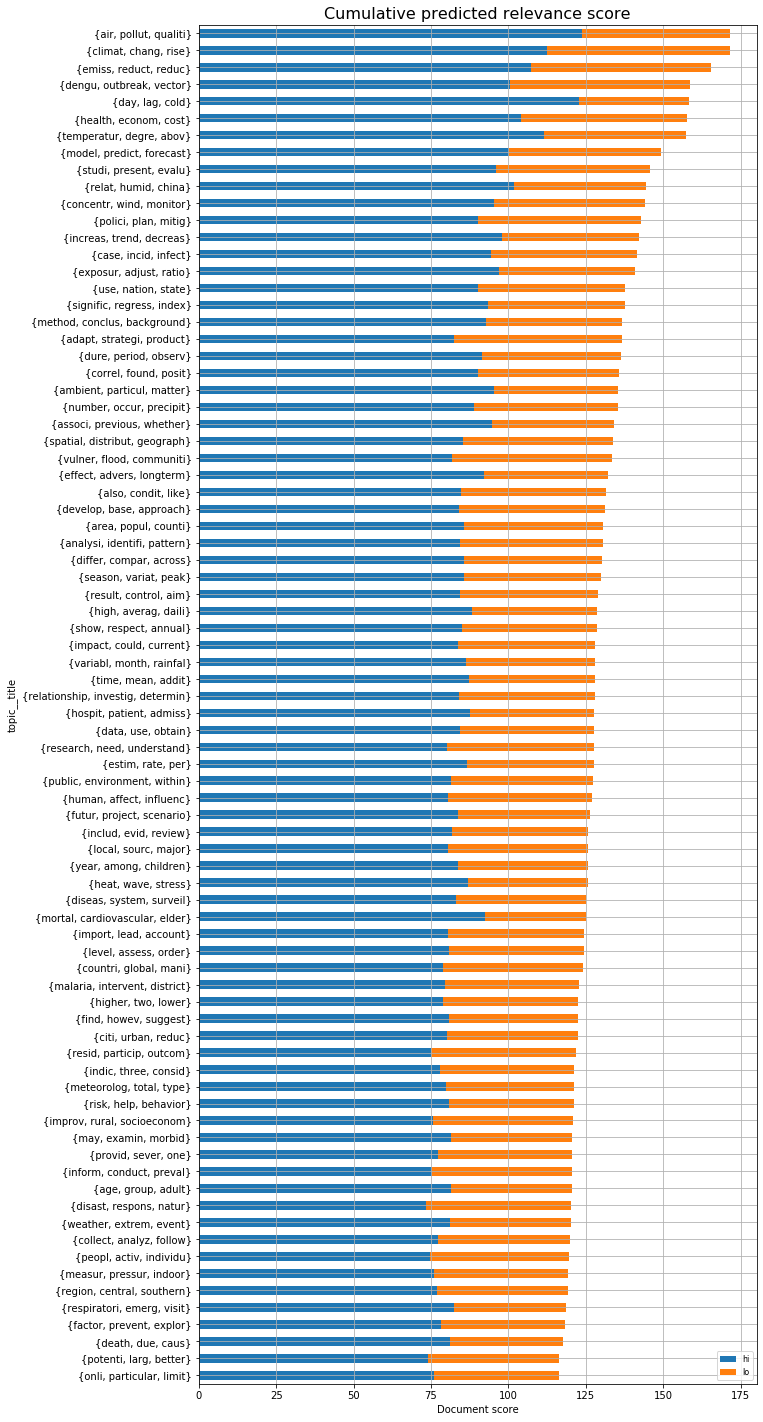

In [330]:
#plot
ax = mergdf[['hi', 'lo']].plot.barh(stacked=True, figsize=(10,25), fontsize=10)

ax.set_xlabel('Document score')
ax.set_title('Cumulative predicted relevance score', fontsize= 16)
ax.grid(True)
ax.legend()

fig.tight_layout()

In [331]:
#create a df with only the highest and lowest *nr* topics
nr = 5
LargeSmall = pd.concat([mergdf.iloc[0:nr], mergdf.iloc[len(mergdf)-nr:len(mergdf)]]
                      ).reset_index(
).set_index('topic__title')

LargeSmall.head()

,hi,lo,sum
topic__title,,,
"{onli, particular, limit}",75.839829,40.579812,116.419641
"{potenti, larg, better}",74.110545,42.349507,116.460052
"{death, due, caus}",80.987138,36.723891,117.711030
"{factor, prevent, explor}",78.330759,39.818754,118.149513
"{respiratori, emerg, visit}",82.484559,35.966083,118.450641


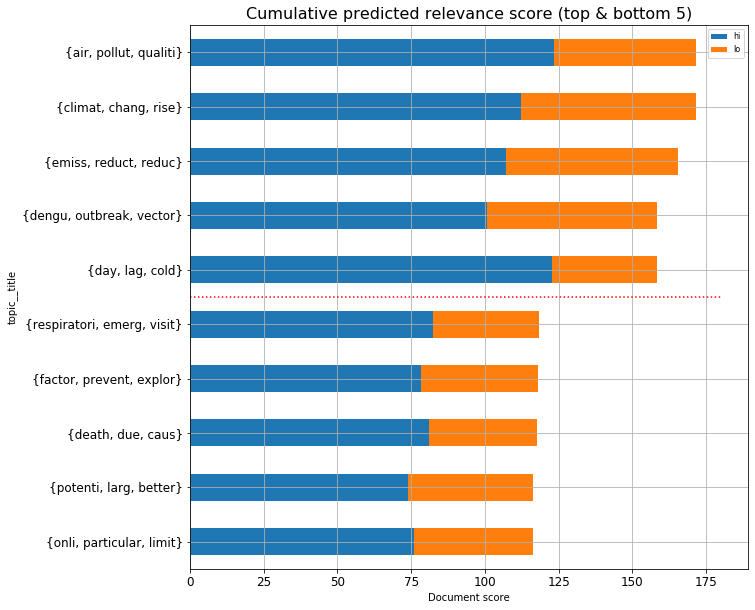

In [332]:
ax = LargeSmall[['hi', 'lo']].plot.barh(
    stacked=True, figsize=(10,10), fontsize=12
)

#plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right') #only for vertical plot

#draw a dotted line between high and low
xmax = ax.get_xlim()
ax.hlines(nr-0.5, xmax[0], xmax[1], color='r', linestyles='dotted')

ax.set_xlabel('Document score')
ax.set_title('Cumulative predicted relevance score (top & bottom 5)', fontsize= 16)
ax.grid(True)
ax.legend()

fig.tight_layout()

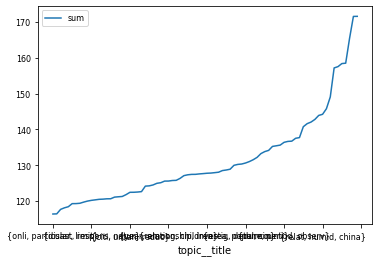

In [333]:
ax = mergdf.plot(y='sum', rot=0)

### Same but now as percentage

In [334]:
mergdf['div'] = mergdf['lo'] / mergdf['sum'] #ratio of low scorers of the total
mergdf = mergdf.sort_values('div')
mergdf.head()

,hi,lo,sum,div
topic__title,,,,
"{day, lag, cold}",122.661950,35.728236,158.390186,0.225571
"{mortal, cardiovascular, elder}",92.481862,32.506392,124.988254,0.260076
"{air, pollut, qualiti}",123.599967,47.973749,171.573716,0.279610
"{temperatur, degre, abov}",111.437314,45.742708,157.180022,0.291021
"{relat, humid, china}",101.896373,42.345480,144.241853,0.293573


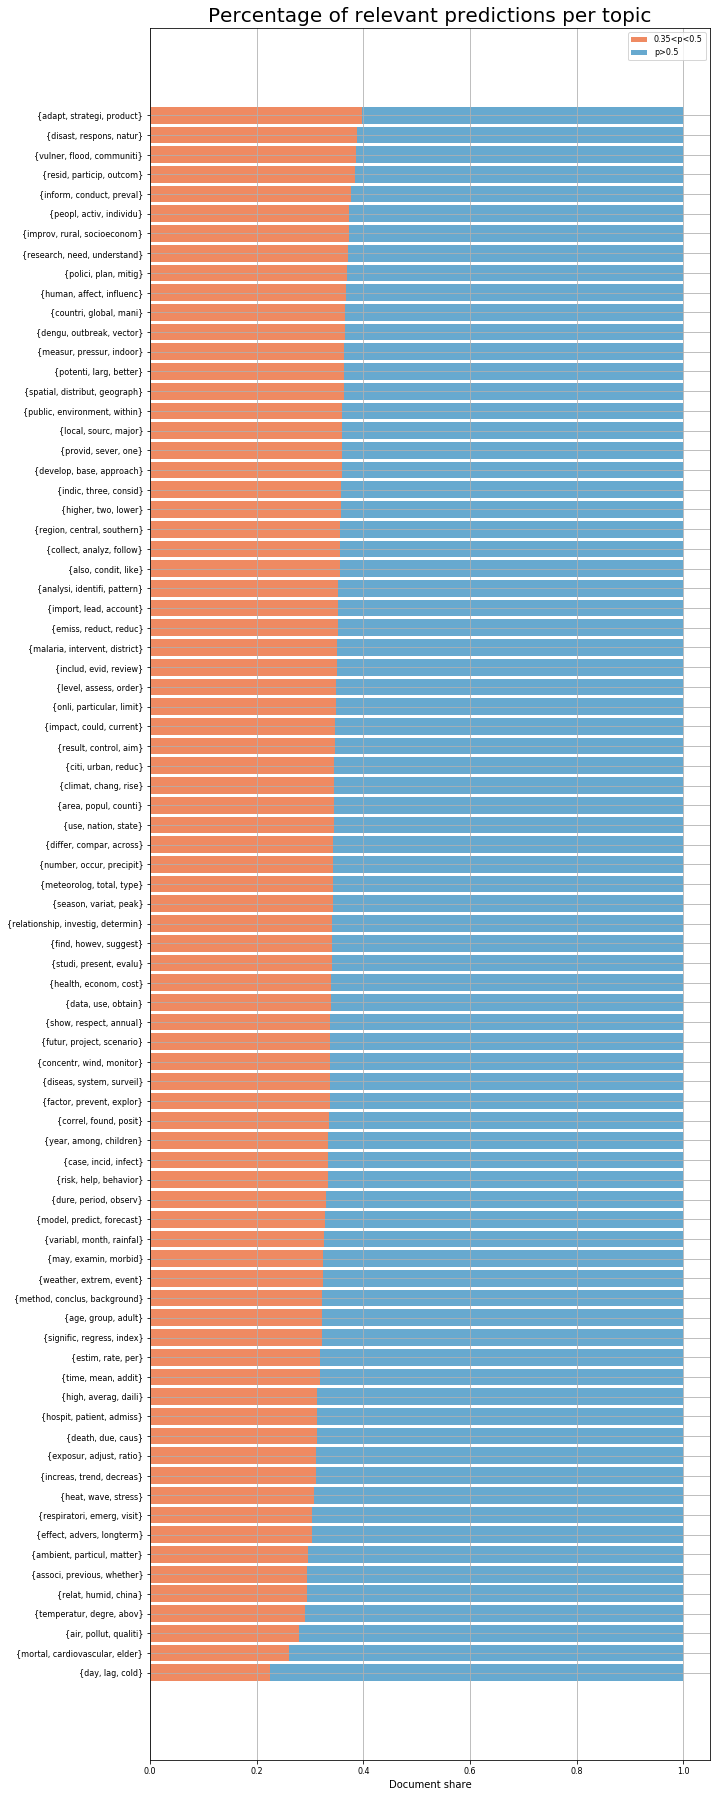

In [346]:
fig = plt.figure(figsize=(10,25), )
ax = fig.add_subplot(111)

ax.barh(mergdf.index,  mergdf['div'],
        align='center',
        height=.85,
        color='#ef8a62',
        label='0.35<p<0.5')
ax.barh(mergdf.index, [1-n for n in mergdf['div']],
        align='center',
        height=.85,
        left=mergdf['div'],
        color='#67a9cf',
        label='p>0.5')

ax.set_yticks(mergdf.index)
ax.set_xlabel('Document share')
ax.set_title('Percentage of relevant predictions per topic', fontsize=20)
ax.grid(True)
ax.legend()

plt.tight_layout()

In [338]:
#And again taking the top and bottom *nr* -- provided the previous table is sorted of course

nr = 3
LargeSmall = pd.concat([mergdf.iloc[0:nr], mergdf.iloc[len(mergdf)-nr:len(mergdf)]]
                      ).reset_index(
).set_index('topic__title')

LargeSmall

,hi,lo,sum,div
topic__title,,,,
"{day, lag, cold}",122.661950,35.728236,158.390186,0.225571
"{mortal, cardiovascular, elder}",92.481862,32.506392,124.988254,0.260076
"{air, pollut, qualiti}",123.599967,47.973749,171.573716,0.279610
"{vulner, flood, communiti}",81.890952,51.385573,133.276525,0.385556
"{disast, respons, natur}",73.520960,46.708795,120.229756,0.388496
"{adapt, strategi, product}",82.340433,54.337109,136.677542,0.397557


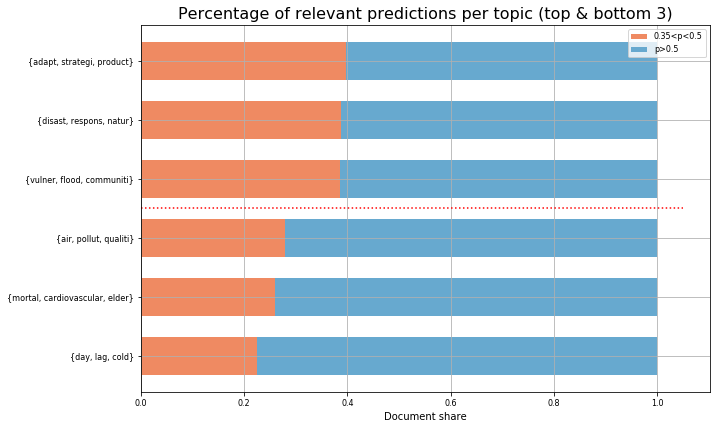

In [348]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.barh(LargeSmall.index,  LargeSmall['div'],
        align='center',
        height=.65,
        color='#ef8a62',
        label='0.35<p<0.5')
ax.barh(LargeSmall.index, [1-n for n in LargeSmall['div']],
        align='center',
        height=.65,
        left=LargeSmall['div'],
        color='#67a9cf',
        label='p>0.5')

ax.set_yticks(LargeSmall.index)
ax.set_xlabel('Document share')
ax.set_title('Percentage of relevant predictions per topic (top & bottom 3)', fontsize=16)
ax.grid(True)
ax.legend()

#draw a dotted line between high and low
xmax = ax.get_xlim()
ax.hlines(nr-0.5, xmax[0], xmax[1], color='r', linestyles='dotted')

plt.tight_layout()

## Using human-labelled data only

In [ ]:
#should run a separate topic model for this

In [47]:
#Getting summed score for each topic
scores = DocTopic.objects.filter(
    run_id=run_id,
    doc__id__in=relevant_ids
).values('topic__title').annotate(
    n = Sum('score')
)

for title, n in enumerate(scores.values('topic__title', 'n')):
    print(n)

{'topic__title': '{adapt, strategi, product}', 'n': 153.6793816851072}
{'topic__title': '{age, group, adult}', 'n': 126.6603886334631}
{'topic__title': '{air, pollut, qualiti}', 'n': 175.81937257711786}
{'topic__title': '{also, condit, like}', 'n': 139.69994789736094}
{'topic__title': '{ambient, particul, matter}', 'n': 140.8651981515464}
{'topic__title': '{analysi, identifi, pattern}', 'n': 138.1225705736919}
{'topic__title': '{area, popul, counti}', 'n': 138.22589346422185}
{'topic__title': '{associ, previous, whether}', 'n': 139.95453039178167}
{'topic__title': '{case, incid, infect}', 'n': 148.1974351640739}
{'topic__title': '{citi, urban, reduc}', 'n': 128.91983090518352}
{'topic__title': '{climat, chang, rise}', 'n': 181.38781798778507}
{'topic__title': '{collect, analyz, follow}', 'n': 127.62658733729657}
{'topic__title': '{concentr, wind, monitor}', 'n': 150.28725194455527}
{'topic__title': '{correl, found, posit}', 'n': 142.69989103498176}
{'topic__title': '{countri, global, m